In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14



In [2]:
import numpy as np
import pandas as pd
from collections import namedtuple
import os
import glob
from pathlib import Path

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms

In [4]:
from torchsummary import summary

In [5]:
from scipy.optimize import curve_fit
from collections import namedtuple

In [6]:
from pymono.mono_dl import MonoDataset, files_list_npy_csv,mono_data_loader

In [7]:
from pymono.aux_func import select_image_and_lbl, get_energy, mean_rms

In [8]:
from pymono.plt_funcs import plot_images, plot_energies2, plot_images_ds, plot_loss, plotxyz, histoplot

In [9]:
from pymono.cnn_func import CNN_basic

In [10]:
from pymono.cnn_eval import train_cnn, evaluate_cnn

In [11]:
from pymono.cnn_fit import fit_coord, fit_tdeltas, plotfxyz

In [ ]:
#from pymono.aux_func import select_image_files, select_image_and_metadata, energy
#from pymono.aux_func import select_image_and_lbl, get_energy, get_means_stds
#from pymono.aux_func import mean_rms, weighted_mean_and_sigma, energy_h3d, corrected_energy

In [ ]:
#from pymono.plt_funcs import plot_true_positions, plot_images, plot_energies, plot_corrected_energy
#from pymono.plt_funcs import  plot_true_predicted, plotxyz, plotxyze, plot_h3d, plot_energies2, plot_loss
#from pymono.plt_funcs import plot_images_ds, histoplot, plot_image_ds, plot_images_ds, plot_image

In [ ]:
#from pymono.cnn_plots import plot_images2

In [ ]:
#from pymono.cnn_func import single_run, CNN_basic, CNN_3x3,train_cnn, evaluate_cnn

In [ ]:
#from pymono.plt_funcs import  plot_energies2, histoplot, plotxyz, plot_dataset

In [ ]:
#from pymono.cnn_plots import plot2c_z, plot_images_and_labels, plot_images_and_positions

In [ ]:
#from pymono.cnn_eval import evaluate_cnn, evaluate_2c_cnn, cnn_xeval, single_run, train_cnn

In [ ]:
#from pymono.cnn_func import ResNet10

In [ ]:
#from pymono.mono_dl import MonoDataset, files_list_npy_csv,mono_data_loader

In [ ]:
#from pymono.cnn_func import CNN_basic

In [ ]:
#from pymono.cnn_fit import fit_coord, fit_tdeltas, plotfxyz

In [ ]:
#from pymono.xdataset import PDataset

In [ ]:
#from pymono.cnn_aux import get_file_names_format1, get_image_file_data, get_img_file_metadata

In [12]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [13]:
data_dir = Path(os.environ['DATA'])
crystal = os.path.join(data_dir,"G4Prods/crystalMT", "csiGammasZX0Img")

In [14]:
crystal

'/Users/jjgomezcadenas/Data/G4Prods/crystalMT/csiGammasZX0Img'

# Setup

- CsI crystal assumed cold (100 k hot/MeV)
- Z generated according to exp(-z/x0)

#### Parameters
- 6x6 SiPMs, thus 8x8 matrix
- 50 k photons per point
- 0MHzDC 
- PTFE wrapping (all sides)
- LUT model
- crystalMT simulation
- old data format (x,y,z)

### CNN comparisons: 
- Compare basic, 3x3 and resnet

## Setup

In [16]:
files_list_npy_csv(crystal)

('images',
 'metadata',
 array([  1,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
         15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
         41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
         54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
         67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
         80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
         93,  94,  95,  96,  97,  98,  99, 100]))

In [17]:
imgs, mdata = select_image_and_lbl(crystal, 3)

Selected files: img = images_5.npy, metdata = metadata_5.csv


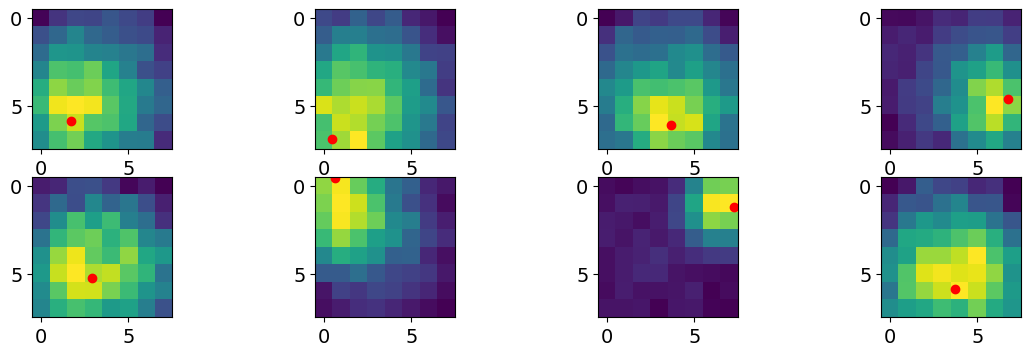

In [18]:
plot_images(imgs, mdata, range(0,8))

In [19]:
imgs[0]

array([[317., 380., 407., 406., 431., 410., 394., 313.],
       [421., 461., 515., 462., 443., 421., 413., 357.],
       [468., 545., 541., 513., 508., 489., 473., 369.],
       [514., 631., 625., 656., 572., 507., 421., 398.],
       [588., 680., 654., 671., 618., 574., 517., 446.],
       [612., 745., 755., 748., 642., 579., 494., 459.],
       [554., 667., 718., 638., 632., 576., 459., 416.],
       [530., 625., 661., 580., 542., 500., 498., 368.]])

In [20]:
energy = get_energy(crystal, 9)

Selected files: img = images_11.npy, metdata = metadata_11.csv


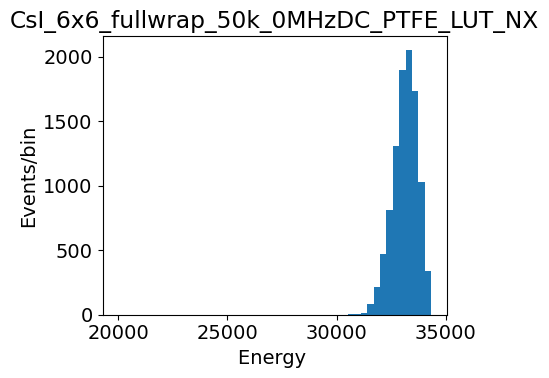

In [21]:
plot_energies2({"CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_NX":energy}, xmin=20000, xmax=max(energy),num_bins = 50)

In [22]:
mean6x6, std6x6, fwhm6x6 = mean_rms(energy)

print(f"mean = {mean6x6:.2f} sigma = {100*std6x6:.2f} % FWHM = {100*fwhm6x6:.2f} %")

mean = 33128.79 sigma = 1.72 % FWHM = 3.95 %


In [23]:
dfg = pd.read_csv(f"{crystal}/metadata_10.csv", header=0)

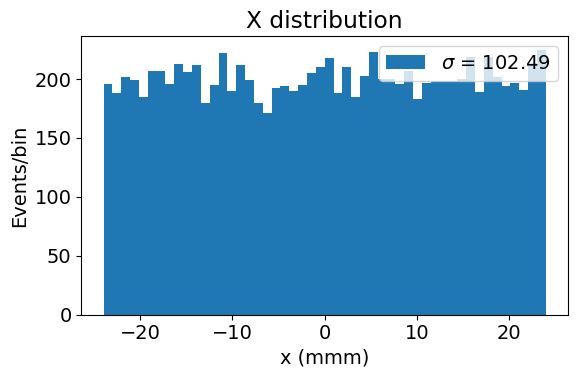

In [24]:
histoplot(dfg["initial_x"], varlbl="x (mmm)", vart="X distribution", num_bins = 50, range=None, figsize=(6, 4))

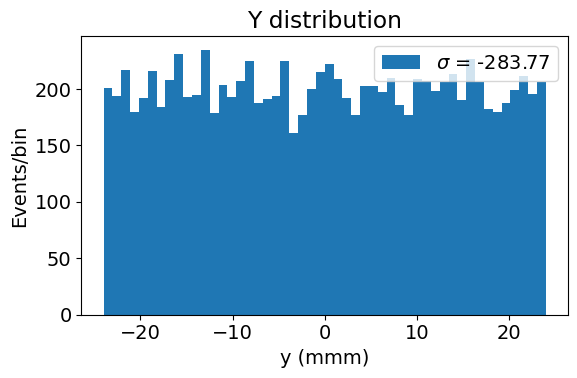

In [25]:
histoplot(dfg["initial_y"], varlbl="y (mmm)", vart="Y distribution", num_bins = 50, range=None, figsize=(6, 4))

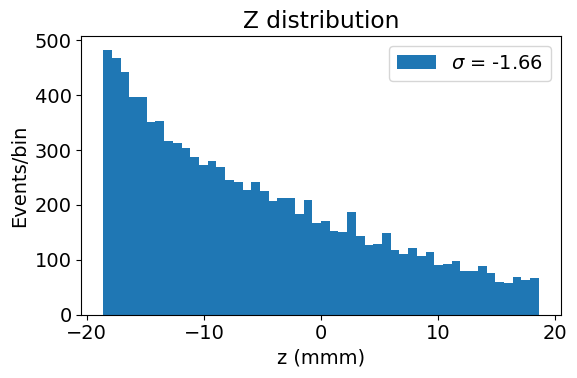

In [26]:
histoplot(dfg["initial_z"], varlbl="z (mmm)", vart="Z distribution", num_bins = 50, range=None, figsize=(6, 4))

## Short run
- 100 files
- No normalization

In [27]:
first_file = 0  # initial file indx
last_file  = 99  # lasta file indx
batch_size = 1000  # Batch size
train_fraction=0.7 
val_fraction=0.2


Variable xyze intoduced to allow two types of format:

1. csv files with format xyz (set xyze == False)
2. csv files with format xyze (set xyze == True)


In [28]:

dataset = MonoDataset(crystal, first_file, last_file, xyze=False)  # No comparison with energy only xyz


Running MonoDataset with norm = False, resize=False, xyze=False
Loading files with indexes: [  1   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37
  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55
  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100]


In [29]:
data_loader, train_loader, val_loader, test_loader = mono_data_loader(dataset, 
                                                                      batch_size=batch_size, 
                                                                      train_fraction=train_fraction, 
                                                                      val_fraction=val_fraction)

Loaded 990000 events
 train size = 693000
 val size = 198000
 test size = 99000
 train indices = range(0, 693000)
 val indices = range(693000, 891000)
 test indices = range(891000, 990000)
693000 training events (70.0%)
198000 validation events (20.0%)
99000 test events (10.0%)


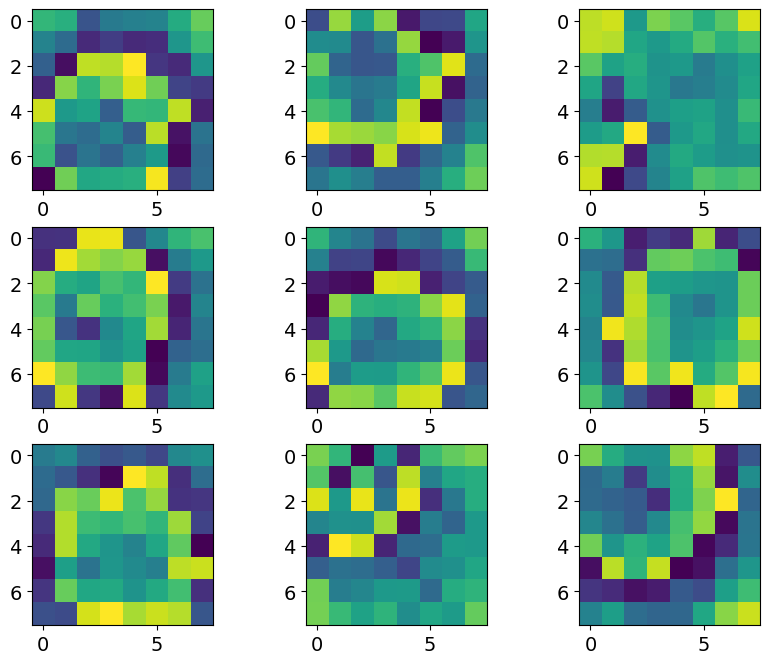

In [30]:
plot_images_ds(dataset, imgs=(0,9), sx=3, figsize=(10, 8))

In [31]:
for images, positions in train_loader:
    print(images.size())
    print(positions.size())
    print(images[0,0,:,:])
    break

torch.Size([1000, 1, 8, 8])
torch.Size([1000, 3])
tensor([[545., 511., 560., 516., 492., 463., 399., 325.],
        [537., 573., 653., 602., 563., 509., 425., 427.],
        [621., 595., 661., 665., 598., 526., 486., 383.],
        [581., 658., 674., 662., 605., 567., 494., 423.],
        [577., 616., 678., 658., 603., 541., 517., 378.],
        [504., 574., 584., 592., 538., 521., 455., 441.],
        [504., 559., 513., 566., 529., 495., 404., 373.],
        [412., 478., 465., 467., 453., 404., 383., 330.]])


In [32]:
model = CNN_basic(chi=128, dropout=False, dropout_fraction=0.2, energy=False).to(device)

In [33]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [34]:
train_losses, val_losses = train_cnn(train_loader, val_loader, model, optimizer, device, criterion, 
                                     batch_size, epochs=10, iprnt=100)

Training with  ->693000 images
size of train loader  ->693 images
Evaluating with  ->198000 images
size of eval loader  ->198 images
Running for epochs ->10

EPOCH 0
input data shape =>torch.Size([1000, 1, 8, 8])
(8,8,1) => (4,4,128) =>torch.Size([1000, 128, 4, 4])
(4,4,128) => (2,2,256) =>torch.Size([1000, 256, 2, 2])
(2,2,256) => (1,1,512) =>torch.Size([1000, 512, 1, 1])
(1,1,512) => (1,1,3) =>torch.Size([1000, 512])
torch.Size([1000, 3])
--- EPOCH 0 AVG TRAIN LOSS: 4.597625419346973
--- EPOCH 0 AVG VAL LOSS: 3.2503415827799325

EPOCH 1
--- EPOCH 1 AVG TRAIN LOSS: 2.877357272358684
--- EPOCH 1 AVG VAL LOSS: 2.656608912679884

EPOCH 2
--- EPOCH 2 AVG TRAIN LOSS: 2.6997120851734158
--- EPOCH 2 AVG VAL LOSS: 3.0582345724105835

EPOCH 3
--- EPOCH 3 AVG TRAIN LOSS: 2.56262271607249
--- EPOCH 3 AVG VAL LOSS: 2.5379505831785876

EPOCH 4
--- EPOCH 4 AVG TRAIN LOSS: 2.4783707979265572
--- EPOCH 4 AVG VAL LOSS: 2.382973215796731

EPOCH 5
--- EPOCH 5 AVG TRAIN LOSS: 2.418838387787944
--- EPOCH 

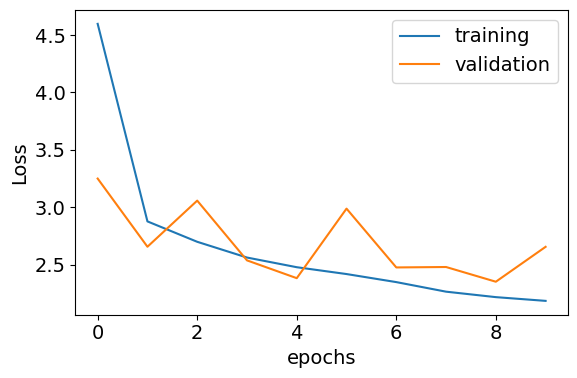

In [35]:
plot_loss(10, train_losses, val_losses,figsize=(6, 4))

In [36]:
tdeltas = evaluate_cnn(test_loader, model, device)

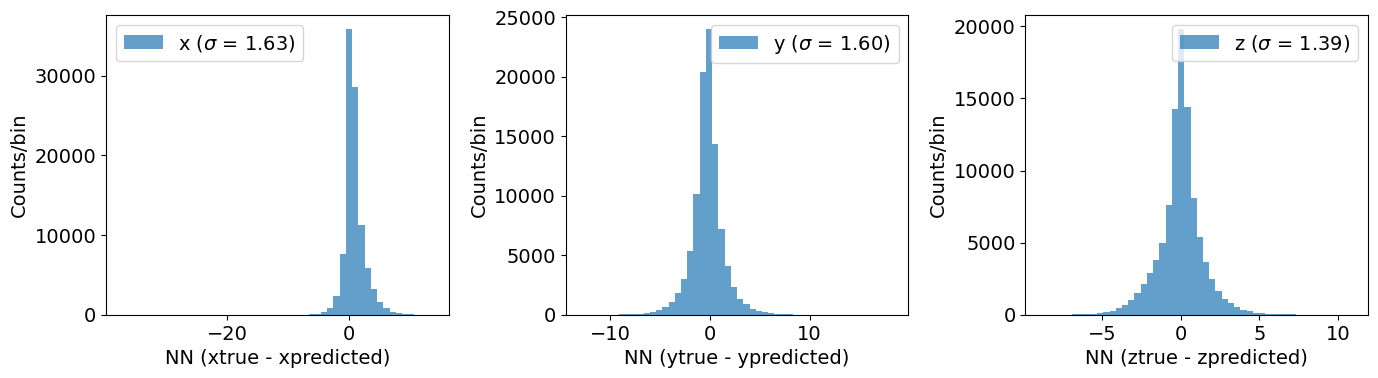

In [37]:
plotxyz(tdeltas, nbins=50)

In [38]:
f2gz, f2gx, f2gy = fit_tdeltas(tdeltas, bins=100)

2g fit: mu1 = 0.03, sigma = 0.39, n1  =0.67
2g fit: mu2 = -0.01, sigma = 1.53, n1  =0.33
weighted error: = 0.77
2g fit: mu1 = 0.36, sigma = 0.50, n1  =0.70
2g fit: mu2 = 1.00, sigma = 1.62, n1  =0.30
weighted error: = 0.83
2g fit: mu1 = -0.22, sigma = 1.76, n1  =0.31
2g fit: mu2 = -0.27, sigma = 0.60, n1  =0.69
weighted error: = 0.96


In [ ]:
plotfxyz(f2gx, f2gy, f2gz, figsize=(14, 4))